In [28]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import antea.reco.reco_functions as rf

In [4]:
filename     = '/Users/carmenromoluque/Desktop/full_body_iradius380mm_z200cm_depth4cm_pitch7mm.022.pet.h5'
sns_response = pd.read_hdf(filename, 'MC/waveforms'       )
tof_response = pd.read_hdf(filename, 'MC/tof_waveforms'   )
particles    = pd.read_hdf(filename, 'MC/particles'       )
hits         = pd.read_hdf(filename, 'MC/hits'            )
sens_pos     = pd.read_hdf(filename, 'MC/sensor_positions')

DataSiPM     = sens_pos.rename(columns={"sensor_id": "SensorID","x": "X", "y": "Y", "z": "Z"})
DataSiPM_idx = DataSiPM.set_index('SensorID')

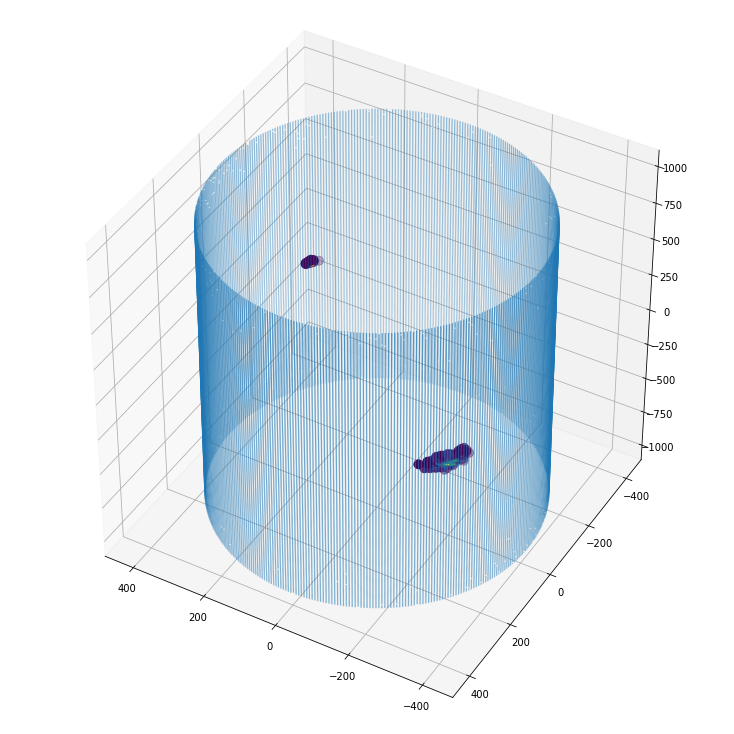

In [26]:
tot_charges = []
events      = particles.event_id.unique()
for evt in events[3:4]:
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=2)
    if len(evt_sns) == 0:
        continue

    evt_parts = particles   [particles   .event_id == evt]
    evt_hits  = hits        [hits        .event_id == evt]
    evt_tof   = tof_response[tof_response.event_id == evt]

    
    max_sns = evt_sns[evt_sns.charge == evt_sns.charge.max()]
    ## If by chance two sensors have the maximum charge, choose one (arbitrarily)
    if len(max_sns != 1):
        max_sns = max_sns[max_sns.sensor_id == max_sns.sensor_id.min()]
    max_sipm = DataSiPM_idx.loc[max_sns.sensor_id]
    max_pos  = np.array([max_sipm.X.values, max_sipm.Y.values, max_sipm.Z.values]).transpose()[0]
    
    sipms         = DataSiPM_idx.loc[evt_sns.sensor_id]
    sns_ids       = sipms.index.astype('int64').values
    sns_positions = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges   = evt_sns.charge
    
    sns1, sns2, pos1, pos2, q1, q2 = rf.divide_sipms_in_two_hemispheres(sns_ids, sns_positions, 
                                                                        sns_charges, max_pos)
    
    tot_q1 = sum(q1)
    tot_q2 = sum(q2)
    
    tot_charges.append(tot_q1)
    tot_charges.append(tot_q2)

    fig = plt.figure(figsize=(10,10))
    ax  = Axes3D(fig)
    pos1_x = np.array([p[0] for p in pos1])
    pos1_y = np.array([p[1] for p in pos1])
    pos1_z = np.array([p[2] for p in pos1])
    pos2_x = np.array([p[0] for p in pos2])
    pos2_y = np.array([p[1] for p in pos2])
    pos2_z = np.array([p[2] for p in pos2])
    ax.scatter(DataSiPM.X.values, DataSiPM.Y.values, DataSiPM.Z.values, marker='o', s=0.1)
    ax.scatter(pos1_x, pos1_y, pos1_z, c=q1, marker='o', s=80)
    ax.scatter(pos2_x, pos2_y, pos2_z, c=q2, marker='o', s=80)
    ax.view_init(azim=120, elev=40)

In [31]:
filepath    = '/Users/carmenromoluque/Desktop/'
evt_ids     = []
tot_charges = []
for filename in os.listdir(compt_filepath):
    if filename.endswith('full_body_charge_and_true_info_22_1_2.npz'):
        print(filename)
        my_file = filepath+filename
        d = np.load(my_file, allow_pickle=True)
        for i in d['tot_charges']:
            tot_charges.append(i)
        for i in d['evt_ids']:
            evt_ids.append(i)
tot_charges = np.array(tot_charges)
evt_ids     = np.array(evt_ids)

full_body_charge_and_true_info_22_1_2.npz


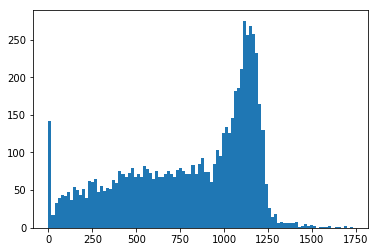

In [33]:
plt.hist(tot_charges, 100);